In [1]:
%load_ext tensorboard

In [2]:
!pip install x-unet
!pip install scikit-learn
!pip install scikit-image

DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can b

In [ ]:
# Set deterministic seeds for reproducibility across runs.
# This sets the Python random seed and PyTorch CPU/CUDA seeds.
import random
import torch

def set_seed(seed: int = 0):
    # Seed Python RNG
    random.seed(seed)
    # Seed PyTorch CPU RNG
    torch.manual_seed(seed)
    # Seed all CUDA devices (if available)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Apply the default seed for reproducible training runs.
set_seed()

In [ ]:
# Configure dataset and output paths used by this notebook.
# `data_path` should point to the directory that contains the `Images` folder.
import os

data_path = 'data'
# Folder containing PNG image files used for training/validation
png_folder = os.path.join(data_path, 'Images')

# Directory to save model checkpoints during training; created if missing.
checkpoints_path = 'checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

In [ ]:
# Dataset class for loading grayscale PNG images and converting them to tensors.
# Images are resized to 256x256 and converted to single-channel tensors.
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image

class HighFrequencyDataset(Dataset):
    def __init__(self, images_path):
        # `images_path`: directory with PNG image files.
        self.images_path = images_path
        # Read and preprocess all images into a tensor on initialization.
        self.images = self.read_images()

    def read_images(self) -> torch.Tensor:
        # Collect PNG file names and open them with PIL.
        image_file_paths = [f for f in os.listdir(self.images_path) if f.lower().endswith('.png')]
        images = [Image.open(os.path.join(self.images_path, img_path)) for img_path in image_file_paths]
        # Transform and stack into a single tensor of shape (N, C, H, W).
        return self.transform_images(images)

    def transform_images(self, images: list[Image]) -> torch.Tensor:
        # Resize images to 256x256 and convert to tensor in range [0, 1].
        transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
        return torch.stack([transform(image) for image in images])

    def __len__(self) -> int:
        # Return number of loaded images.
        return len(self.images)

    def __getitem__(self, idx) -> torch.Tensor:
        # Return the preprocessed tensor for the given index.
        return self.images[idx]


In [ ]:
# Instantiate the dataset using the configured `png_folder`.
# This will load and preprocess all images into memory.
dataset = HighFrequencyDataset(png_folder)

In [ ]:
# Split dataset into training and validation subsets and create data loaders.
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Use an 80/20 split with a fixed random state for reproducibility.
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

# DataLoader wraps datasets for batching and optional shuffling.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# Image quality metrics used to evaluate denoising performance.
# PSNR: peak signal-to-noise ratio, higher is better.
# SSIM: structural similarity index, ranges [-1, 1], higher is better.
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    # Convert tensors to NumPy arrays on CPU and compute PSNR assuming images in [0,1].
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    # Compute SSIM
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

In [ ]:
# K space

def fft2_image(x):
    # x: [B, C, H, W] torch tensor
    return torch.fft.fft2(x, norm='ortho')

def ifft2_image(k):
    # k: [B, C, H, W] complex tensor
    return torch.fft.ifft2(k, norm='ortho').real

def add_gaussian_noise_kspace(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    """
    Add Gaussian noise in K-space to a batch of images.
    """
    kspace = fft2_image(x)
    # Create noise tensor of same shape
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(kspace) * sigmas
    noisy_kspace = kspace + noise
    x_noisy = ifft2_image(noisy_kspace)
    return x_noisy, sigmas


In [ ]:
# Build the XUnet model and move it to the selected device (GPU if available).
import torch
from x_unet import XUnet

# Instantiate the model with parameters suitable for 256x256 grayscale images.
unet = XUnet(
    dim=64,                           # base width; 64 works well for 256x256
    channels=1,                       # grayscale input
    dim_mults=(1, 2, 4, 8),           # 4 scales -> 256→128→64→32 bottleneck
    nested_unet_depths=(7, 4, 2, 1),  # U²-Net-style nested depths
    consolidate_upsample_fmaps=True,  # fuse upsample features (as in U²-Net paper)
    weight_standardize=True           # helps stability on medical data
)

# Choose device and transfer model weights to it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = unet.to(device)

In [ ]:
# Configure optimizer and loss function for training.
import torch
import torch.nn as nn

LEARNING_RATE = 1e-4

# Adam optimizer is used for stable convergence.
opt = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE)

# Mean squared error is an appropriate pixel-wise loss for denoising.
mse_loss = nn.MSELoss()

In [ ]:
# Training loop: add noise, predict noise, and optimize the network.
from tqdm import tqdm

# Maximal standard deviation used to corrupt images during training.
NOISE_STD = 0.08
# Number of training epochs.
EPOCHS = 5
# Subdirectory for saving this model variant's checkpoints.
MODEL_OUT_DIR = os.path.join(checkpoints_path, "nested-unet-kspace")

os.makedirs(MODEL_OUT_DIR, exist_ok=True)

# Track best validation loss for checkpointing.
best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    # Set model to training mode.
    unet.train()
    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")

    train_loss = 0.0

    for x in pbar:
        # Move batch to device.
        x = x.to(device)
        # Add Gaussian noise to inputs.
        x_noisy, _ = add_gaussian_noise_kspace(x, NOISE_STD)
        # The target for the network is the added noise (residual learning).
        added_noise = x_noisy - x
        # Predict the noise component from the noisy image.
        pred_noise = unet(x_noisy)  # predict noise
        # Compute MSE between predicted and true noise.
        loss = mse_loss(added_noise, pred_noise)  # MSE loss
        # Backward pass and optimization step.
        loss.backward()
        opt.step()
        opt.zero_grad(set_to_none=True)

        train_loss += loss.item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # Average training loss across batches.
    train_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch} | train {train_loss:.8f}")

    # validation: evaluate model without gradient updates.
    val_loss = 0.0
    with torch.no_grad():
        for xv in iter(val_loader):
            xv = xv.to(device)
            xv_noisy, _ = add_gaussian_noise_kspace(xv, NOISE_STD)
            added_noise = xv_noisy - xv
            pred_noise = unet(xv_noisy)
            val_loss += mse_loss(pred_noise, added_noise).item()
    val_loss /= len(val_loader)

    # Save checkpoint if validation loss improved.
    if val_loss < best_val:
        best_val = val_loss
        torch.save(unet.state_dict(), os.path.join(MODEL_OUT_DIR, "best_model.pt"))

    tqdm.write(f"Epoch {epoch} | val {val_loss:.8f} | best {best_val:.8f}")

Epoch 1/5:   0%|                                                                                                                                                                                      | 0/1626 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:32<00:00,  1.86it/s, loss=0.0008]


Epoch 1 | train 0.00604491
Epoch 1 | val 0.00058620 | best 0.00058620


Epoch 2/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:31<00:00,  1.86it/s, loss=0.0003]


Epoch 2 | train 0.00054236
Epoch 2 | val 0.00036699 | best 0.00036699


Epoch 3/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:32<00:00,  1.86it/s, loss=0.0004]


Epoch 3 | train 0.00037882
Epoch 3 | val 0.00033294 | best 0.00033294


Epoch 4/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:32<00:00,  1.86it/s, loss=0.0004]


Epoch 4 | train 0.00034199
Epoch 4 | val 0.00032283 | best 0.00032283


Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:32<00:00,  1.86it/s, loss=0.0005]


Epoch 5 | train 0.00292954
Epoch 5 | val 0.00038713 | best 0.00032283


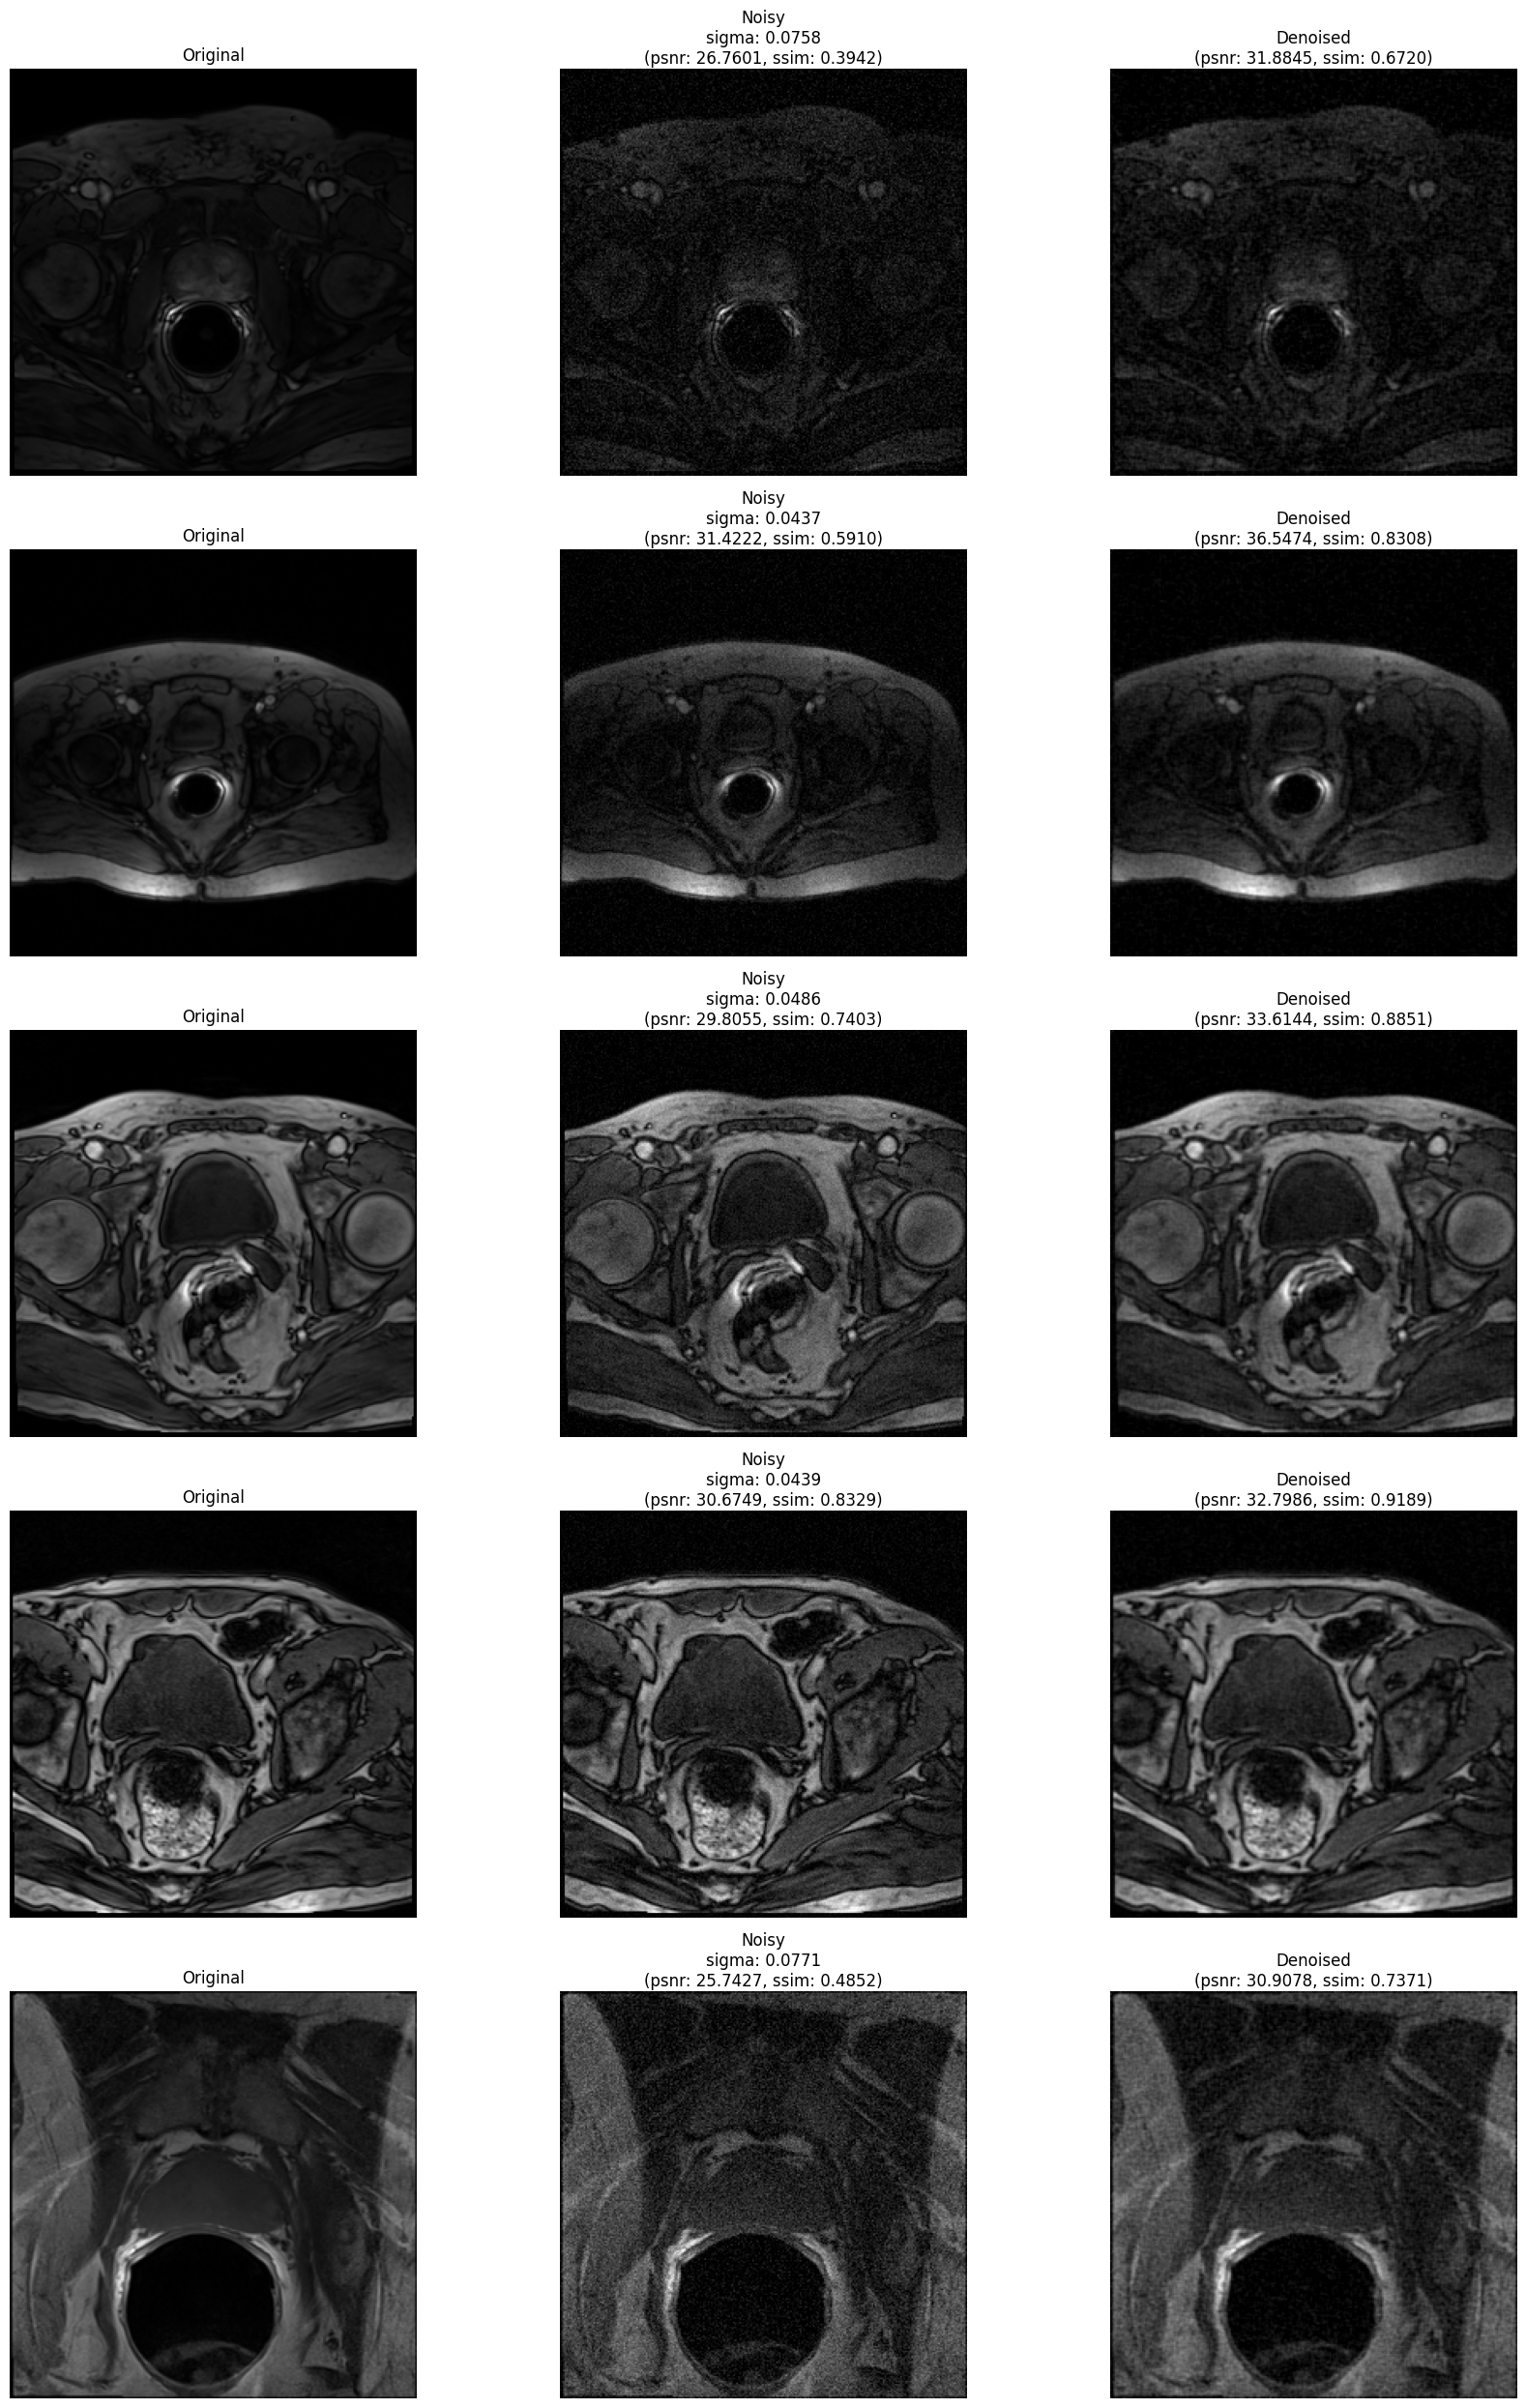

In [ ]:
# Visualize a few examples from the validation set: original, noisy, and denoised.
import matplotlib.pyplot as plt
import torch

# Concatenate dataset tensors and add channel dimension expected by the model.
vd = torch.concat(val_dataset).unsqueeze(1)

# Randomly choose 5 examples to display.
random_indices = torch.randint(0, len(vd), (5,))
plt.figure(figsize=(18, 25))

with torch.no_grad():
    for i, xv in enumerate(vd[random_indices]):
        xv = xv.to(device).unsqueeze(0)
        # Add noise using a sampled sigma between 0.03 and 0.08.
        xv_noisy, sigma = add_gaussian_noise_kspace(xv, 0.08, 0.03)
        pred_noise = unet(xv_noisy)
        # Reconstruct denoised image by subtracting predicted noise.
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        clamped_noisy = xv_noisy.clamp(0, 1)

        # Original image
        plt.subplot(5, 3, i * 3 + 1)
        plt.imshow(xv.cpu().numpy().squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Noisy input with sigma and metrics in title
        plt.subplot(5, 3, i * 3 + 2)
        plt.imshow(clamped_noisy.cpu().numpy().squeeze(), cmap="gray")
        plt.title(
            f"Noisy\nsigma: {sigma.item():.4f}\n(psnr: {compute_psnr(xv.squeeze(), clamped_noisy.squeeze()):.4f}, ssim: {compute_ssim(xv.squeeze(), clamped_noisy.squeeze()):.4f})",
            wrap=True,
        )
        plt.axis("off")

        # Denoised output with metrics
        plt.subplot(5, 3, i * 3 + 3)
        plt.imshow(pred.cpu().numpy().squeeze(), cmap="gray")
        plt.title(
            f"Denoised\n(psnr: {compute_psnr(xv.squeeze(), pred.squeeze()):.4f}, ssim: {compute_ssim(xv.squeeze(), pred.squeeze()):.4f})",
            wrap=True,
        )
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Compute aggregate metrics for the validation set and compare noisy vs denoised.
noised_loss = []
noised_psnr = []
noised_ssim = []

validation_loss = []
validation_psnr = []
validation_ssim = []

for xv in tqdm(vd):
    with torch.no_grad():
        # Move single-sample tensor to device.
        xv = xv.to(device)
        # Add noise with a sampled sigma in the same range used for visualization.
        xv_noisy, _ = add_gaussian_noise_kspace(xv, max_sigma=0.08, min_sigma=0.03)
        clamped_noisy = xv_noisy.clamp(0, 1)

        # Denoise by predicting and subtracting noise.
        pred_noise = unet(xv_noisy)
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        
    # Record metrics for the noisy input.
    noised_loss.append(mse_loss(xv, clamped_noisy).item())
    noised_psnr.append(compute_psnr(xv.squeeze(), clamped_noisy.squeeze()))
    noised_ssim.append(compute_ssim(xv.squeeze(), clamped_noisy.squeeze()))

    # Record metrics for the denoised output.
    validation_loss.append(mse_loss(xv, pred).item())
    validation_psnr.append(compute_psnr(xv.squeeze(), pred.squeeze()))
    validation_ssim.append(compute_ssim(xv.squeeze(), pred.squeeze()))

# Print average metrics across the validation set.
print(f"Noised Loss: {sum(noised_loss)/len(noised_loss)}")
print(f"Noised PSNR: {sum(noised_psnr)/len(noised_psnr)}")
print(f"Noised SSIM: {sum(noised_ssim)/len(noised_ssim)}")

print(f"Validation Loss: {sum(validation_loss)/len(validation_loss)}")
print(f"Validation PSNR: {sum(validation_psnr)/len(validation_psnr)}")
print(f"Validation SSIM: {sum(validation_ssim)/len(validation_ssim)}")

  0%|                                                                                                                                                                                                 | 0/6502 [00:00<?, ?it/s]/users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6502/6502 [07:50<00:00, 13.81it/s]

Noised Loss: 0.0012419890961126358
Noised PSNR: 29.688412763907642
Noised SSIM: 0.6111580318499186
Validation Loss: 0.0004592052309244013
Validation PSNR: 33.82972844623932
Validation SSIM: 0.8082052675244032
